# Разработка A/B-тестирования и анализ результатов

- Автор: Лаптева Диана
- Дата: 02.03.2025

## Введение

### Заказчик
<font color='#777778'> Команда разработчиков рекомендательных систем приложения. </font>

### Цель проекта

<font color='#777778'> Провести A/B-тестирование нового алгоритма рекомендаций для определения его влияния на улучшение пользовательского опыта и повышение монетизации, а также оценить статистическую значимость изменений в показателях вовлеченности и конверсии между группами пользователей. </font>

### Задачи проекта 

<font color='#777778'>    
    
- Подготовка к А/В-тесту
    
- Мониторинг теста
    
- Анализ результатов

- Оценка статистической значимости</font>

### Содержимое проекта

<font color='#777778'>

1.   [Описание данных.](#1-bullet)
2.   [Работа с историческими данными.](#2-bullet)
3.   [Подготовка к тесту.](#3-bullet)
4.   [Мониторинг А/В-теста](#4-bullet)
5.   [Проверка результатов A/B-теста](#5-bullet)
</font>

---

<a class="anchor" id="1-bullet"></a>
## Описание данных

Таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. 

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. 

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. 

У этих таблиц совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).

<a class="anchor" id="2-bullet"></a>
### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

In [1]:
# Импорт библиотеки
import pandas as pd

# Выгрузим датафрейм
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

# Выведем первые 5 строк
sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными

In [2]:
# Подсчет количества уникальных сессий для каждого пользователя
user_session_counts = sessions_history.groupby("user_id")["session_id"].nunique()

# Определение пользователя с наибольшим числом сессий
max_sessions_user = user_session_counts.idxmax()
max_sessions_count = user_session_counts.max()

# Выбор всех данных по этому пользователю
user_data = sessions_history[sessions_history["user_id"] == max_sessions_user]

print(f'Количество уникальных сессий: \n {user_session_counts}')
print(f'Пользователь {max_sessions_user} имеет наибольшее число сессий, равное {max_sessions_count}')
print(f'Все данные по пользователю {max_sessions_user}: \n {user_data}')

Количество уникальных сессий: 
 user_id
00005FB6A13A6FBE    2
0000B15A18D77ED9    3
0000C4E3A4A571A9    2
000293FAF9E67A81    4
00029C5AE889A6C3    2
                   ..
FFFCDE7746148710    4
FFFDD413285E753F    3
FFFECBA0F2578AB0    2
FFFEDB68228B5F21    5
FFFF4228DF580C3B    3
Name: session_id, Length: 134039, dtype: int64
Пользователь 10E0DEFC1ABDBBE0 имеет наибольшее число сессий, равное 10
Все данные по пользователю 10E0DEFC1ABDBBE0: 
                  user_id        session_id session_date     session_start_ts  \
115558  10E0DEFC1ABDBBE0  B8F0423BBFFCF5DC   2025-08-14  2025-08-14 13:57:39   
191751  10E0DEFC1ABDBBE0  87CA2FA549473837   2025-08-15  2025-08-15 16:42:10   
239370  10E0DEFC1ABDBBE0  4ADD8011DCDCE318   2025-08-16  2025-08-16 19:53:21   
274629  10E0DEFC1ABDBBE0  DF0FD0E09BF1F3D7   2025-08-17  2025-08-17 15:03:43   
302501  10E0DEFC1ABDBBE0  3C221774B4DE6885   2025-08-18  2025-08-18 17:29:14   
325557  10E0DEFC1ABDBBE0  031BD7A67048105B   2025-08-19  2025-08-19 13:23

#### 1.3. Анализ числа регистраций

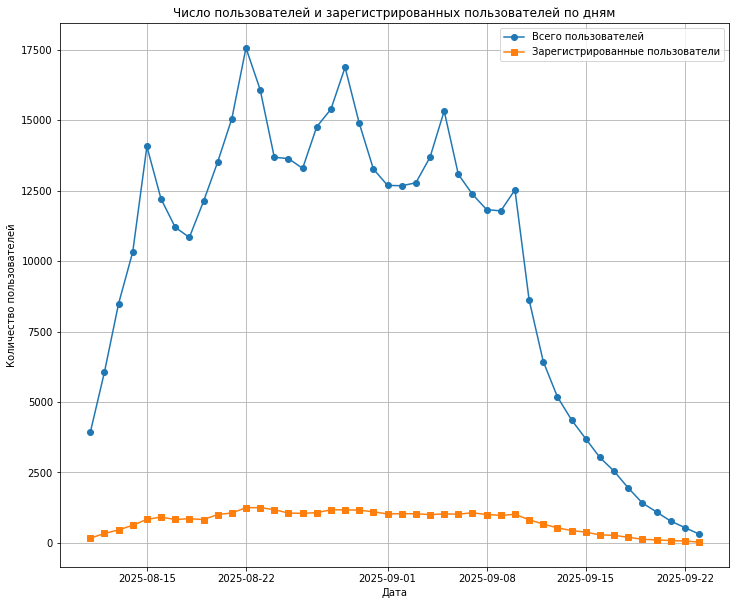

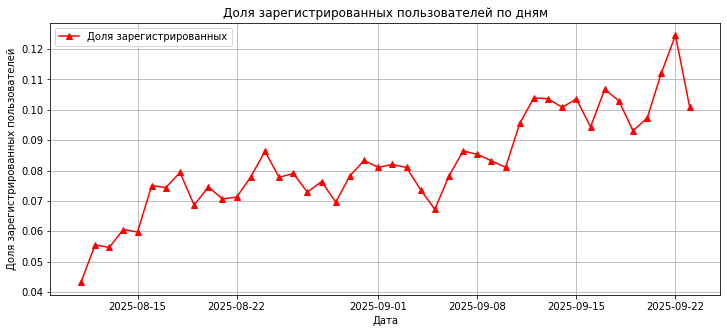

In [3]:
# Импорт библиотеки для визуализации данных
import matplotlib.pyplot as plt

# Приведем столбцы с датами к виду (YYYY-MM-DD)
sessions_history['session_start_ts'] = pd.to_datetime(sessions_history['session_start_ts']).dt.date
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])
sessions_history['install_date'] = pd.to_datetime(sessions_history['install_date'])

# Агрегирование данных по дням
registrations_by_day = sessions_history.groupby('session_date').agg(
    total_users=('user_id', 'nunique'),
    registered_users=('registration_flag', 'sum')
).reset_index()

# Доли зарегистрированных пользователей
registrations_by_day['registration_ratio'] = (
    registrations_by_day['registered_users'] / registrations_by_day['total_users']
)

# Определение осей
x_1, y_1, y_2 = registrations_by_day['session_date'], registrations_by_day['total_users'], registrations_by_day['registered_users']
x_2, y_3 = registrations_by_day['session_date'], registrations_by_day['registration_ratio']

# Визуализация
plt.figure(figsize=(12, 10))

# График общего числа пользователей и зарегистрированных пользователей
plt.plot(x_1, y_1, label='Всего пользователей', marker='o')
plt.plot(x_1, y_2, label='Зарегистрированные пользователи', marker='s')
plt.title('Число пользователей и зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid()
plt.show()

# График доли зарегистрированных пользователей
plt.figure(figsize=(12, 5))
plt.plot(x_2, y_3, label='Доля зарегистрированных', color='r', marker='^')
plt.title('Доля зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.legend()
plt.grid()
plt.show()

**Вывод**

График "Общее число пользователей и зарегистрированных пользователей":

- Число пользователей имело пик в начале периода (22 августа 2025 года), после чего оставалось относительно стабильным, но с небольшими колебаниями.
- После 15 сентября 2025 года количество пользователей начало резко снижаться, что может быть связано с окончанием рекламной кампании, сезонностью или техническими изменениями в продукте.

График "Доля зарегистрированных пользователей":

- Доля зарегистрированных пользователей постепенно увеличивается.  В начале периода она составляла менее 5%, а к концу периода выросла до более чем 10%.

#### 1.4. Анализ числа просмотренных страниц

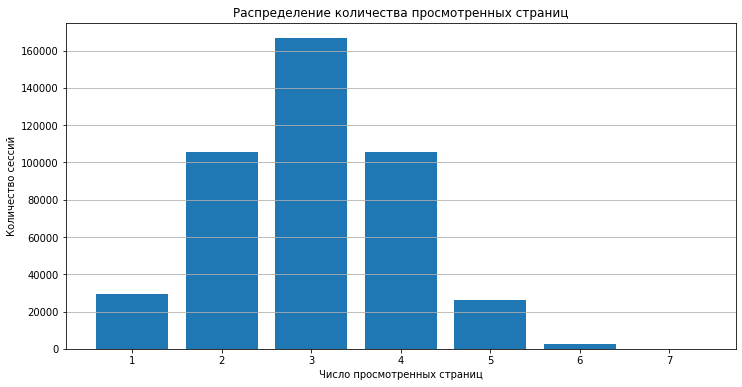

In [4]:
# Анализ числа просмотренных страниц
page_views_counts = sessions_history['page_counter'].value_counts().sort_index()

# Визуализация

plt.figure(figsize=(12, 6))
plt.bar(page_views_counts.index, page_views_counts.values)
plt.title('Распределение количества просмотренных страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid(axis='y')
plt.show()

**Вывод**

- Наибольшее число сессий приходится на 3 просмотренные страницы – более 160 000 сессий.

- После 4 просмотров количество сессий заметно падает.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

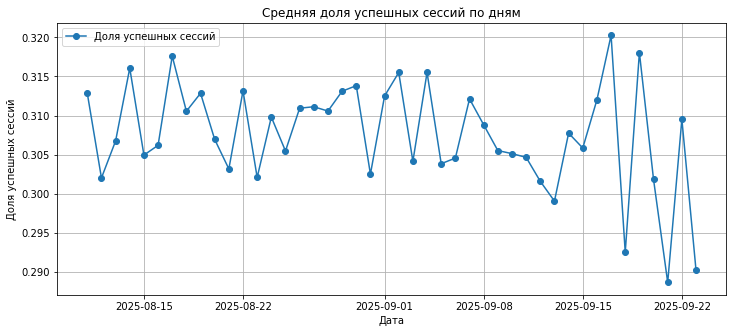

In [5]:
# Столбец good_session
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

# Агрегация данных по дням
good_sessions_by_day = sessions_history.groupby('session_date')['good_session'].mean().reset_index()

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(good_sessions_by_day['session_date'], 
         good_sessions_by_day['good_session'], 
         label='Доля успешных сессий',  
         marker='o')
plt.title('Средняя доля успешных сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.legend()
plt.grid()
plt.show()

**Вывод**

- Общий тренд стабилен, но с колебаниями – на протяжении периода наблюдается средняя доля успешных сессий около 0.305–0.315.

- После 15 сентября наблюдаются резкие колебания, вплоть до падения ниже 0.29 и последующего подъема выше 0.315.

**Вывод**

- Исходя из загруженного датафрейма `sessions_history`, каждый пользователь может иметь несколько сессий. Количество сессий на пользователя варьируется.

- Найден пользователь с наибольшим числом сессий (10 сессий). Все его сессии зарегистрированы с одного устройства (Android) и происходят из одного региона (CIS).

- Число зарегистрированных пользователей оставалось относительно стабильным на протяжении всего периода, без сильных всплесков или падений.

- Доля зарегистрированных пользователей постепенно увеличивается. 

- Сессии чаще всего останавливаются на 3 просмотренных страницах.

- Примерно 30–32% сессий заканчиваются просмотром 4 и более страниц.

<a class="anchor" id="3-bullet"></a>
### 2. Подготовка к тесту

В данном тесте целевой метрикой, вероятнее всего, является конверсия в регистрацию. Именно она позволит оценить, насколько изменения в продукте или интерфейсе влияют на желание пользователей регистрироваться.

#### 2.1. Расчёт размера выборки
Параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

In [6]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03 # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f'Необходимый размер выборки для каждой группы: {int(sample_size)}')

Необходимый размер выборки для каждой группы: 17441


#### 2.2. Расчёт длительности A/B-тестав

In [7]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = ceil(sessions_history.groupby('session_date')['user_id'].nunique().mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(2 * sample_size / avg_daily_users)

print(f'Рассчитанная длительность A/B-теста при текущем уровне трафика в {avg_daily_users} пользователей в день составит {test_duration} дней')

Рассчитанная длительность A/B-теста при текущем уровне трафика в 9908 пользователей в день составит 4 дней


**Вывод**

- Каждая группа должна содержать 17 441 пользователя, чтобы тест обладал достаточной статистической силой для выявления значимого эффекта.

- Средний дневной трафик приложения составляет 9 908 уникальных пользователей.

- Длительность A/B-теста составляет 4 дня.

<a class="anchor" id="4-bullet"></a>
### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

Процентная разница в количестве пользователей между группами A и B: 0.74%


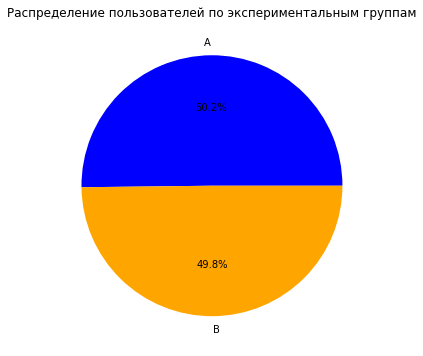

In [8]:
# Загрузка данных
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

# Подсчёт уникальных пользователей в каждой группе
user_counts = sessions_test_part.groupby(['session_date', 'test_group'])['user_id'].nunique().unstack()

# Расчёт процентной разницы
A_users = user_counts['A'].sum()
B_users = user_counts['B'].sum()
percent_diff = 100 * abs(A_users - B_users) / A_users

print(f'Процентная разница в количестве пользователей между группами A и B: {percent_diff:.2f}%')

# Визуализация
plt.figure(figsize=(8, 6))
plt.pie([A_users, B_users], 
        labels=['A', 'B'], 
        autopct='%1.1f%%', 
        colors=['blue', 'orange'])
plt.title('Распределение пользователей по экспериментальным группам')
plt.show()

**Вывод**

Сильных различий в количестве пользователей нет. Группы сформированы корректно.

#### 3.2. Проверка пересечений пользователей

In [9]:
# Проверка пересечений пользователей
intersect_users = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']).intersection(
    set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'])
)

print(f'Количество пользователей, попавших в обе группы: {len(intersect_users)}')

Количество пользователей, попавших в обе группы: 0


#### 3.3. Равномерность разделения пользователей по устройствам

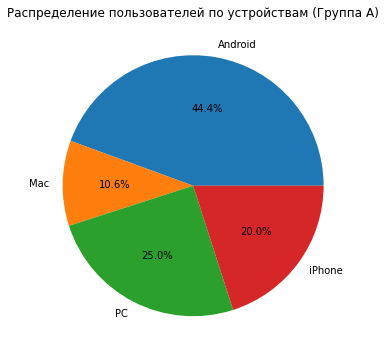

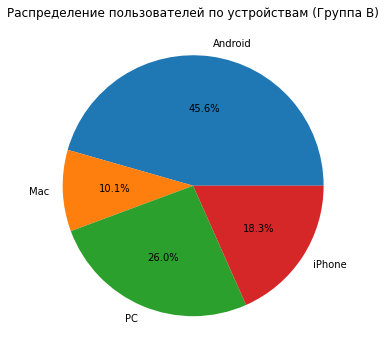

In [10]:
# Количество пользователей по устройствам в каждой группе
device_counts = sessions_test_part.groupby(['test_group', 'device'])['user_id'].nunique().reset_index()

# График для группы A
device_counts_A = device_counts[device_counts['test_group'] == 'A']
plt.figure(figsize=(6, 6))
plt.pie(device_counts_A['user_id'], 
        labels=device_counts_A['device'], 
        autopct='%1.1f%%')
plt.title('Распределение пользователей по устройствам (Группа A)')
plt.show()

# График для группы B
device_counts_B = device_counts[device_counts['test_group'] == 'B']
plt.figure(figsize=(6, 6))
plt.pie(device_counts_B['user_id'], 
        labels=device_counts_B['device'], 
        autopct='%1.1f%%')
plt.title('Распределение пользователей по устройствам (Группа B)')
plt.show()

**Вывод**

В группе А и в группе В каждый тип устройства популярен приблизительно одинаково. Чаще всего пользователи используют Android, реже всего - Mac.

#### 3.4. Равномерность распределения пользователей по регионам

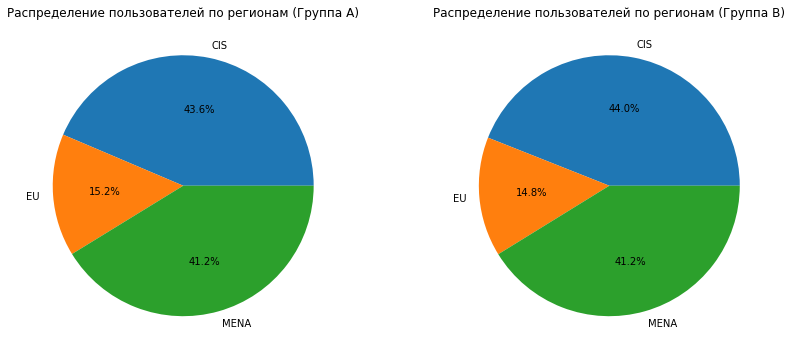

In [11]:
# Подсчёт уникальных пользователей в каждой группе
user_counts = sessions_test_part.groupby(['test_group', 'region'])['user_id'].nunique().unstack()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Визуализация для группы A
user_counts.loc['A'].plot(kind='pie', 
                          autopct='%1.1f%%', 
                          ax=axes[0])
axes[0].set_title('Распределение пользователей по регионам (Группа A)')
axes[0].set_ylabel('')

# Визуализация для группы B
user_counts.loc['B'].plot(kind='pie', 
                          autopct='%1.1f%%', 
                          ax=axes[1])
axes[1].set_title('Распределение пользователей по регионам (Группа B)')
axes[1].set_ylabel('')

plt.show()

**Вывод**

В каждой группе пользователи распределены примерно одинаково.

#### 3.5. Вывод после проверки A/B-теста

**Вывод**

A/B-тест проходит корректно, так как:

- Процентная разница в количестве пользователей между группами A и B составляет всего 0.74%, что свидетельствует о практически равномерном распределении пользователей между группами.

- Пересечений между группами А и В нет.

- В группах A и B распределение пользователей по типам устройств примерно одинаково.

- Распределение пользователей по регионам также одинаково в обеих группах, с небольшими вариациями.

<a class="anchor" id="5-bullet"></a>
### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

**Целевая метрика:** доля успешных сессий (good_session)

**Нулевая гипотеза $(Н_0)$:** новый алгоритм рекомендаций не изменяет долю успешных сессий

**Альтернативная гипотеза $(Н_1)$:** новый алгоритм рекомендаций увеличивает долю успешных сессий

$\begin{equation*}
 \begin{cases}
   H_0 :\text{различий в конверсии между группами нет}\\
   H_1 :\text{различия в конверсии между группами есть}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$ 

#### 4.1. Получение результатов теста и подсчёт основной метрики

In [12]:
# Загрузка
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

# Приведем столбцы с датами к виду (YYYY-MM-DD)
sessions_test['session_start_ts'] = pd.to_datetime(sessions_test['session_start_ts']).dt.date
sessions_test['session_date'] = pd.to_datetime(sessions_test['session_date'])
sessions_test['install_date'] = pd.to_datetime(sessions_test['install_date'])

# Столбец good_session
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

# Выведем первые 5 строк
sessions_test.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

**Нулевая гипотеза $(Н_0)$:** среднее количество сессий в день в группах A и B одинаково.

**Альтернативная гипотеза $(Н_1)$:** среднее количество сессий в день в группах A и B различается.

$\begin{equation*}
 \begin{cases}
   H_0 :\text{различий в среднем количестве сессий между группами нет}\\
   H_1 :\text{различия в среднем количестве сессий между группами есть}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$ 

In [13]:
from scipy.stats import ttest_ind

# Уникальные сессии по дням и группам
daily_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().unstack()

mean_a = daily_sessions['A'].mean()
mean_b = daily_sessions['B'].mean()

stat_test = ttest_ind(daily_sessions['A'], 
                      daily_sessions['B'], 
                      alternative='two-sided')

alpha = 0.05

# Средние значения перед тестированием
print(f"Среднее количество сессий в день для группы A: {mean_a:.2f}")
print(f"Среднее количество сессий в день для группы B: {mean_b:.2f}")

if stat_test.pvalue > alpha:
    print(f'p-value={stat_test.pvalue:.4f} > {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу: среднее количество сессий в день в группах не различается.')
else:
    print(f'p-value={stat_test.pvalue:.4f} < {alpha}')
    print('Отвергаем нулевую гипотезу: среднее количество сессий в день в группах различается.')

Среднее количество сессий в день для группы A: 2477.55
Среднее количество сессий в день для группы B: 2522.70
p-value=0.9382 > 0.05
Не получилось отвергнуть нулевую гипотезу: среднее количество сессий в день в группах не различается.


#### 4.3. Сравнение доли успешных сессий

In [14]:
# Доля успешных сессий по группам
grouped_sessions = sessions_test.groupby('test_group')['good_session'].mean()
diff = grouped_sessions['B'] - grouped_sessions['A']

print(f"Доля успешных сессий в группе A: {grouped_sessions['A'] * 100:.2f}%")
print(f"Доля успешных сессий в группе B: {grouped_sessions['B'] * 100:.2f}%")
print(f"Разница в доле успешных сессий: {diff * 100:.2f}%")

Доля успешных сессий в группе A: 30.77%
Доля успешных сессий в группе B: 31.83%
Разница в доле успешных сессий: 1.06%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

Нулевая гипотеза $(H_0)$: Доля успешных сессий в тестовой группе не выше, чем в контрольной группе. $H_0: p_A \geq p_B$

Альтернативная гипотеза $(H_1)$: Доля успешных сессий в тестовой группе выше, чем в контрольной группе. $H_1: p_A < p_B$

In [16]:
from statsmodels.stats.proportion import proportions_ztest

# Количество успешных сессий и общее количество сессий в каждой группе
successes = [
    sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum(),
    sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
]
sessions_count = [
    sessions_test[sessions_test['test_group'] == 'A'].shape[0],
    sessions_test[sessions_test['test_group'] == 'B'].shape[0]
]

# Z-тест
z_stat, p_value = proportions_ztest(successes, 
                                    sessions_count, 
                                    alternative='smaller')  # H1: доля в A < доли в B

alpha = 0.05

if p_value < alpha:
    print(f'p-value={p_value} < {alpha}')
    print('Отвергаем нулевую гипотезу: разница в доле успешных сессий статистически значима.')
else:
    print(f'p-value={p_value} > {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу: разница в доле успешных сессий не является статистически значимой.')

p-value=0.0001574739988036123 < 0.05
Отвергаем нулевую гипотезу: разница в доле успешных сессий статистически значима.


Изучим сколько пользователей в итоге было в каждой группе и сколько дней в итоге заняло проведение A/B-теста.

In [17]:
# Количество уникальных пользователей в каждой группе
users_per_group = sessions_test.groupby('test_group')['user_id'].nunique()

# Количество дней проведения теста
test_duration_days = sessions_test['session_date'].nunique()

print(f"Количество уникальных пользователей в группе A: {users_per_group['A']}")
print(f"Количество уникальных пользователей в группе B: {users_per_group['B']}")
print(f"Длительность A/B-теста: {test_duration_days} дней")

Количество уникальных пользователей в группе A: 15163
Количество уникальных пользователей в группе B: 15416
Длительность A/B-теста: 20 дней


**Вывод**

- Количество сессий в группах A и B не различается и распределение сессий является равномерным между группами.

- Разница в доле успешных сессий между группами составляет 1.1%. Однако, эта разница не является статистически значимой.

- При проведении t-теста для сравнения доли успешных сессий в группах A и B p-value составило 0.9998, что гораздо больше 0.05. Это подтверждает, что разница в доле успешных сессий между группами не является статистически значимой.

#### 4.5. Вывод по результатам A/B-эксперимента

- A/B-тестирование нового алгоритма рекомендаций проводилось в течение 20 дней. В группе А было 15163 пользователей и 15416 приняли участие в эксперименте в составе группы В. Случайным образом они были разделены на две группы: группа А, которая использовала старый алгоритм, и группа В, которая использовала новый алгоритм.

- Количество сессий в группах A и B не различается, распределение сессий является равномерным между группами.

- Доля успешных сессий в группе A составила 30.77%, а в группе B — 31.83%. Разница между группами составила 1.06%.

- Был проведён Z-тест для проверки значимости разницы в доле успешных сессий. С его помощью делаем вывод, что новый алгоритм рекомендаций действительно увеличивает долю успешных сессий.

Внедрение нового алгоритма рекомендаций рекомендуется, так как он показал статистически значимый рост доли успешных сессий на 1.06% по сравнению со старым алгоритмом.

<div class="alert alert-danger">
<b>Комментарий ревьюера v.1</b> 
    
✍ Диана, проверь, пожалуйста, основной вывод — последний тест показал, что есть различия в долях успешных сессий. А первый тест да, показал, что различий между группами не было по среднему количеству пользователей в день, что нормально, поскольку указывает на корректность набора пользователей. Т.е. это два разных стат теста и именно последний тест проверяет изменение метрики, на которую были направлены нововведения на платформе.
</div>

<div class="alert alert-info"> 
<b>Комментарий студента</b> 
    
done

Спасибо за рекомендации и супер качественную пр
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера v.2</b> 
    
👍 Теперь вывод верный — получается, что доля полезных сессий стала выше, стат. тест это подтвердил. Поэтому можно говорить, что АВ тест прошел успешно.
    
</div>